In [ ]:
# ------------------------------
# Initial text cleaning and merging
# ------------------------------

import pandas as pd
import numpy as np
import re
import nltk
import glob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from google.colab import drive

drive.mount('/content/drive')

## Load Data
folder_path = "/content/drive/MyDrive/machine_learning/project/data_2025/2025/train/*.parquet"
folder_path_test = "/content/drive/MyDrive/machine_learning/project/data_2025/2025/test/*.parquet"
files = glob.glob(folder_path)
files2 = glob.glob(folder_path_test)
etsy_train_df = pd.concat([pd.read_parquet(file) for file in files], ignore_index=True)
etsy_test_df = pd.concat([pd.read_parquet(file) for file in files2], ignore_index=True)

print(etsy_train_df.shape)
etsy_train_df.head()
print(etsy_test_df.shape)
etsy_test_df.head()

for col in etsy_train_df.columns:
  print(f'Unique value in {col} - {etsy_train_df[col].nunique()}')
etsy_train_df['material'].value_counts()
desc_freq = pd.Series(' '.join(etsy_train_df['description']).split()).value_counts()[:20]
desc_freq

for col in etsy_test_df.columns:
  print(f'Unique value in {col} - {etsy_test_df[col].nunique()}')
etsy_test_df['material'].value_counts()
desc_freq1 = pd.Series(' '.join(etsy_test_df['description']).split()).value_counts()[:20]
desc_freq1


## Pre- Process
# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


# Tokenization, Stopword Removal, Stemming, and Lemmatization
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\n', ' ', text)  # Remove newlines
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters

    # Tokenization
    tokens = word_tokenize(text)

    # Stopword Removal
    tokens = [word for word in tokens if word not in stop_words and word not in desc_freq]
    
    # Stemming and Lemmatization
    #stemmed_tokens = [stemmer.stem(word) for word in tokens]  # Apply stemming
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(lemmatized_tokens)

etsy_train_df['title_clean'] = etsy_train_df['title'].apply(clean_text)
etsy_train_df['description_clean'] = etsy_train_df['description'].apply(clean_text)
etsy_train_df['tags_clean'] = etsy_train_df['tags'].apply(clean_text)

etsy_train_df.to_parquet("/content/drive/MyDrive/ML Dataset/cleaned_train.parquet", index=False)
etsy_test_df.to_parquet("/content/drive/MyDrive/ML Dataset/cleaned_test.parquet", index=False)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import warnings
import os
warnings.filterwarnings('ignore')

from datetime import datetime
from scipy import sparse
from scipy.sparse import hstack, vstack, csr_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
from joblib import Parallel, delayed
from sentence_transformers import SentenceTransformer

In [ ]:
# ------------------------------
# 1. Configuring Parameters
# ------------------------------
# Pipeline selection
USE_BERT = True  # Set to True to use Sentence-BERT embeddings
USE_TFIDF = True  # Set to True to use TF-IDF+SVD features
USE_METADATA = True  # Set to True to use metadata features (categorical + numeric)

# General parameters
USE_GPU = True  # Use GPU acceleration if available
USE_SMOTE = True  # Use SMOTE for handling class imbalance
MIN_SAMPLES_BOTTOM_CAT = 50  # Minimum samples per bottom category
SVD_COMPONENTS = 250  # Number of SVD components
TFIDF_MAX_FEATURES = 3000  # Max features for TF-IDF
BERT_MODEL = 'paraphrase-MiniLM-L6-v2'  # Sentence-BERT model to use
RANDOM_STATE = 42 
USE_PARALLEL = True  # Use parallel processing for training
USE_FLOAT32 = True  # Use float32 instead of float64 to save memory
BATCH_SIZE = 5000  # Batch size for predictions to manage memory usage
N_FOLDS = 5  # Number of cross-validation folds
TEST_SIZE = 0.2  # Train/test split ratio

Configuration: USE_BERT=True, USE_TFIDF=True, USE_METADATA=True, GPU=True, SMOTE=True


In [3]:
# ------------------------------
# 2. Data Loading and Initial Exploration
# ------------------------------
product_data = pd.read_parquet("./train/cleaned_train.parquet")
    
test_data = pd.read_parquet("./test/cleaned_test.parquet")
    
print("--------Train Dataset--------")
print(f"Dataset shape: {product_data.shape}")
print(f"Column names: {product_data.columns.tolist()}")
print(f"Number of unique top categories: {product_data['top_category_id'].nunique()}")
print(f"Number of unique bottom categories: {product_data['bottom_category_id'].nunique()}")

print("--------Test Dataset--------")
print(f"Dataset shape: {test_data.shape}")
print(f"Column names: {test_data.columns.tolist()}")

--------Train Dataset--------
Dataset shape: (229624, 26)
Column names: ['product_id', 'title', 'description', 'tags', 'type', 'room', 'craft_type', 'recipient', 'material', 'occasion', 'holiday', 'art_subject', 'style', 'shape', 'pattern', 'bottom_category_id', 'bottom_category_text', 'top_category_id', 'top_category_text', 'primary_color_id', 'primary_color_text', 'secondary_color_id', 'secondary_color_text', 'title_clean', 'description_clean', 'tags_clean']
Number of unique top categories: 15
Number of unique bottom categories: 2609
--------Test Dataset--------
Dataset shape: (25514, 18)
Column names: ['product_id', 'title', 'description', 'tags', 'type', 'room', 'craft_type', 'recipient', 'material', 'occasion', 'holiday', 'art_subject', 'style', 'shape', 'pattern', 'title_clean', 'description_clean', 'tags_clean']


In [4]:
# ------------------------------
# 3. Data Preprocessing
# ------------------------------
product_ids = product_data["product_id"].copy()
    
# Drop ID columns to prevent data leakage
ID_COLUMNS = ['product_id']
print(f"Dropping ID columns that could cause data leakage: {ID_COLUMNS}")
product_data = product_data.drop(columns=[col for col in ID_COLUMNS if col in product_data.columns])
    
# Handle missing values in text columns
text_columns = ['title', 'description', 'tags']
for col in text_columns:
    if col in product_data.columns:
        product_data[text_columns] = product_data[text_columns].fillna("")

# Check for cleaned text columns or use original
text_columns_clean = ['title_clean', 'description_clean', 'tags_clean']
use_clean_text = all(col in product_data.columns for col in text_columns_clean)
    
# Create text length features
if 'title' in product_data.columns and 'title_length' not in product_data.columns:
    product_data['title_length'] = product_data['title'].str.len()
if 'description' in product_data.columns and 'description_length' not in product_data.columns:
    product_data['description_length'] = product_data['description'].str.len()
if 'tags' in product_data.columns and 'tags_length' not in product_data.columns:
    product_data['tags_length'] = product_data['tags'].str.len()
    product_data['tags_count'] = product_data['tags'].str.count(' ') + 1

Dropping ID columns that could cause data leakage: ['product_id']


In [5]:
# ------------------------------
# 4. Train/Test Split and Feature Creation
# ------------------------------
def split_data(product_data):
    """Split data into training and test sets with stratification"""
    print("Performing train/test split before any feature engineering to prevent data leakage")
    
    # Define features and labels
    features = product_data.drop(['top_category_id', 'top_category_text', 
                                  'bottom_category_id', 'bottom_category_text'], 
                                 axis=1, errors='ignore')
    top_category_labels = product_data['top_category_id'].values
    bottom_category_labels = product_data['bottom_category_id'].values
    
    # Create a combined target for stratification to preserve hierarchy
    product_data['strat_target'] = (product_data['top_category_id'].astype(str) + "_" + 
                                  product_data['bottom_category_id'].astype(str))
    strat_target = product_data['strat_target'].values
    
    # Use stratified split to maintain distribution of both targets
    (features_train, features_test, 
     top_category_labels_train, top_category_labels_test, 
     bottom_category_labels_train, bottom_category_labels_test, 
     strat_train, strat_test) = train_test_split(
        features, top_category_labels, bottom_category_labels, strat_target,
        test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=strat_target
    )
    
    print(f"Training set size: {features_train.shape[0]}")
    print(f"Test set size: {features_test.shape[0]}")
    
    return (features_train, features_test, 
            top_category_labels_train, top_category_labels_test, 
            bottom_category_labels_train, bottom_category_labels_test)

(features_train, features_test, 
 top_category_labels_train, top_category_labels_test, 
 bottom_category_labels_train, bottom_category_labels_test) = split_data(product_data)


def handle_rare_categories(bottom_category_labels_train, bottom_category_labels_test):
    """Group rare bottom categories with fewer than MIN_SAMPLES_BOTTOM_CAT samples"""
    # Calculate bottom category counts only from training data to avoid leakage
    bottom_cat_counts_train = pd.Series(bottom_category_labels_train).value_counts()
    min_samples = bottom_cat_counts_train.min()
    rare_categories = bottom_cat_counts_train[bottom_cat_counts_train < MIN_SAMPLES_BOTTOM_CAT].index.tolist()
    
    print(f"Minimum samples per bottom category in training set: {min_samples}")
    print(f"Number of rare bottom categories (<{MIN_SAMPLES_BOTTOM_CAT} samples): {len(rare_categories)}")
    
    # Group rare categories in both train and test sets
    def group_rare_categories(category_labels, rare_cats):
        grouped_labels = np.copy(category_labels)
        for i, cat in enumerate(category_labels):
            if cat in rare_cats:
                grouped_labels[i] = -1  # -1 for rare categories
        return grouped_labels
    
    bottom_category_labels_train_grouped = group_rare_categories(bottom_category_labels_train, rare_categories)
    bottom_category_labels_test_grouped = group_rare_categories(bottom_category_labels_test, rare_categories)
    
    return bottom_category_labels_train_grouped, bottom_category_labels_test_grouped

(bottom_category_labels_train_grouped, 
 bottom_category_labels_test_grouped) = handle_rare_categories(
    bottom_category_labels_train, 
    bottom_category_labels_test
)
def create_combined_text(features_train, features_test, use_clean_text):
    """Create combined text features from title, description, and tags"""
    if use_clean_text:
        features_train['combined_text'] = (
            features_train['title_clean'] + ' ' + 
            features_train['description_clean'] + ' ' + 
            features_train['tags_clean']
        )
        features_test['combined_text'] = (
            features_test['title_clean'] + ' ' + 
            features_test['description_clean'] + ' ' + 
            features_test['tags_clean']
        )
    else:
        features_train['combined_text'] = (
            features_train['title'] + ' ' + 
            features_train['description'] + ' ' + 
            features_train['tags']
        )
        features_test['combined_text'] = (
            features_test['title'] + ' ' + 
            features_test['description'] + ' ' + 
            features_test['tags']
        )
    
    return features_train, features_test
features_train, features_test = create_combined_text(features_train, features_test, use_clean_text)


Performing train/test split before any feature engineering to prevent data leakage
Training set size: 183699
Test set size: 45925
Minimum samples per bottom category in training set: 34
Number of rare bottom categories (<50 samples): 76


In [6]:
# ------------------------------
# 5. Feature Engineering
# ------------------------------

# Create basic numeric text features
features_train['title_length'] = features_train['title'].str.len()
features_test['title_length'] = features_test['title'].str.len()

features_train['description_length'] = features_train['description'].str.len()
features_test['description_length'] = features_test['description'].str.len()

features_train['tags_length'] = features_train['tags'].str.len()
features_test['tags_length'] = features_test['tags'].str.len()

features_train['tags_count'] = features_train['tags'].str.count(' ') + 1
features_test['tags_count'] = features_test['tags'].str.count(' ') + 1

numeric_features = [
    'title_length', 'description_length', 'tags_length', 'tags_count'
]

categorical_features = [
    'type', 'room', 'craft_type', 'recipient', 'material',
    'occasion', 'holiday', 'art_subject', 'style', 'shape', 'pattern',
    'primary_color_text', 'secondary_color_text'
]
def extract_features_with_tfidf(features_train, features_test, categorical_features, numeric_features):
    """Process features using TF-IDF + SVD pipeline"""
    # Text features
    print("Processing text features with TF-IDF...")
    tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, ngram_range=(1, 2))
    train_text_features = tfidf.fit_transform(features_train['combined_text'])
    test_text_features = tfidf.transform(features_test['combined_text'])
    
    if USE_FLOAT32:
        train_text_features = train_text_features.astype(np.float32)
        test_text_features = test_text_features.astype(np.float32)
    
    print(f"Text feature shape: {train_text_features.shape}")
    
    # Categorical features
    print("Processing categorical features...")
    if categorical_features and USE_METADATA:
        categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
        train_categorical_features = categorical_transformer.fit_transform(features_train[categorical_features])
        test_categorical_features = categorical_transformer.transform(features_test[categorical_features])
        
        if USE_FLOAT32:
            train_categorical_features = train_categorical_features.astype(np.float32)
            test_categorical_features = test_categorical_features.astype(np.float32)
        
        print(f"Categorical feature shape: {train_categorical_features.shape}")
    else:
        train_categorical_features = csr_matrix((features_train.shape[0], 0))
        test_categorical_features = csr_matrix((features_test.shape[0], 0))
        categorical_transformer = None
        print("No categorical features used")
    
    # Numeric features
    print("Processing numeric features...")
    if numeric_features and USE_METADATA:
        numeric_transformer = StandardScaler()
        train_numeric_features = numeric_transformer.fit_transform(features_train[numeric_features])
        test_numeric_features = numeric_transformer.transform(features_test[numeric_features])
        
        if USE_FLOAT32:
            train_numeric_features = train_numeric_features.astype(np.float32)
            test_numeric_features = test_numeric_features.astype(np.float32)
        
        print(f"Numeric feature shape: {train_numeric_features.shape}")
    else:
        train_numeric_features = np.zeros((features_train.shape[0], 0))
        test_numeric_features = np.zeros((features_test.shape[0], 0))
        numeric_transformer = None
        print("No numeric features used")
    
    # Combine features
    print("Combining features...")
    train_combined_features = hstack([
        train_text_features, 
        train_categorical_features, 
        csr_matrix(train_numeric_features)
    ])
    test_combined_features = hstack([
        test_text_features, 
        test_categorical_features, 
        csr_matrix(test_numeric_features)
    ])
    
    # Apply SVD for dimensionality reduction
    print("Applying TruncatedSVD for dimensionality reduction...")
    svd = TruncatedSVD(n_components=SVD_COMPONENTS, random_state=RANDOM_STATE)
    train_svd_features = svd.fit_transform(train_combined_features)
    test_svd_features = svd.transform(test_combined_features)
    
    if USE_FLOAT32:
        train_svd_features = train_svd_features.astype(np.float32)
        test_svd_features = test_svd_features.astype(np.float32)
    
    print(f"SVD feature matrix shape: {train_svd_features.shape}")
    print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")
    
    return (train_svd_features, test_svd_features, 
            tfidf, categorical_transformer, numeric_transformer, svd)

tfidf_features_train, tfidf_features_test, tfidf_vectorizer, categorical_encoder, numeric_scaler, svd_model = extract_features_with_tfidf(
    features_train, features_test, categorical_features, numeric_features
)

def extract_features_with_bert(features_train, features_test):
    """Process features using Sentence-BERT embeddings"""
    print(f"Loading Sentence-BERT model: {BERT_MODEL}...")
    bert_model = SentenceTransformer(BERT_MODEL)
    
    # Extract embeddings in batches to manage memory usage
    def extract_embeddings(texts):
        print(f"Encoding {len(texts)} texts using Sentence-BERT...")
        return bert_model.encode(
            texts,
            batch_size=32,
            show_progress_bar=True
        )
    
    print("Extracting BERT embeddings for training data...")
    train_bert_features = extract_embeddings(features_train['combined_text'].tolist())

    print("Extracting BERT embeddings for test data...")
    test_bert_features = extract_embeddings(features_test['combined_text'].tolist())
    
    if USE_FLOAT32:
        train_bert_features = train_bert_features.astype(np.float32)
        test_bert_features = test_bert_features.astype(np.float32)
    
    print(f"BERT feature matrix shape: {train_bert_features.shape}")
    
    return train_bert_features, test_bert_features, bert_model

bert_features_train, bert_features_test, bert_model = extract_features_with_bert(
    features_train, features_test
)

def combine_feature_sets(tfidf_features_train, tfidf_features_test, 
                         bert_features_train=None, bert_features_test=None):
    """Combine features from multiple pipelines"""
    if tfidf_features_train is not None and bert_features_train is not None:
        print("Combining TF-IDF+SVD and BERT features...")
        combined_train_features = np.hstack([tfidf_features_train, bert_features_train])
        combined_test_features = np.hstack([tfidf_features_test, bert_features_test])
        print(f"Combined feature matrix shape: {combined_train_features.shape}")
    elif tfidf_features_train is not None:
        print("Using only TF-IDF+SVD features...")
        combined_train_features = tfidf_features_train
        combined_test_features = tfidf_features_test
    elif bert_features_train is not None:
        print("Using only BERT features...")
        combined_train_features = bert_features_train
        combined_test_features = bert_features_test
    else:
        raise ValueError("At least one feature extraction method must be enabled")
    
    return combined_train_features, combined_test_features

combined_features_train, combined_features_test = combine_feature_sets(
    tfidf_features_train=tfidf_features_train,
    tfidf_features_test=tfidf_features_test,
    bert_features_train=bert_features_train,
    bert_features_test=bert_features_test
)

Processing text features with TF-IDF...
Text feature shape: (183699, 3000)
Processing categorical features...
Categorical feature shape: (183699, 535)
Processing numeric features...
Numeric feature shape: (183699, 4)
Combining features...
Applying TruncatedSVD for dimensionality reduction...
SVD feature matrix shape: (183699, 250)
Explained variance ratio: 0.9008
Loading Sentence-BERT model: paraphrase-MiniLM-L6-v2...
Extracting BERT embeddings for training data...
Encoding 183699 texts using Sentence-BERT...


Batches:   0%|          | 0/5741 [00:00<?, ?it/s]

Extracting BERT embeddings for test data...
Encoding 45925 texts using Sentence-BERT...


Batches:   0%|          | 0/1436 [00:00<?, ?it/s]

BERT feature matrix shape: (183699, 384)
Combining TF-IDF+SVD and BERT features...
Combined feature matrix shape: (183699, 634)


Training top category classifier with XGBoost and cross-validation
Using GPU acceleration for XGBoost
Performing 5-fold cross-validation for top category model
Training fold 1/5
Fold 1 - Accuracy: 0.8284, F1: 0.8026
Training fold 2/5
Fold 2 - Accuracy: 0.8277, F1: 0.8000
Training fold 3/5
Fold 3 - Accuracy: 0.8275, F1: 0.8000
Training fold 4/5
Fold 4 - Accuracy: 0.8311, F1: 0.8029
Training fold 5/5
Fold 5 - Accuracy: 0.8291, F1: 0.8004
Average CV Accuracy: 0.8288, F1: 0.8012
Top category test results:
Test Accuracy: 0.8352
Test Macro F1: 0.8093
Test Weighted F1: 0.8322
Classification Report - Top Category:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      2481
           1       0.83      0.53      0.65      1746
           2       0.81      0.76      0.78      1331
           3       0.86      0.76      0.81      2259
           4       0.85      0.76      0.80      1251
           5       0.90      0.95      0.92      6034
       

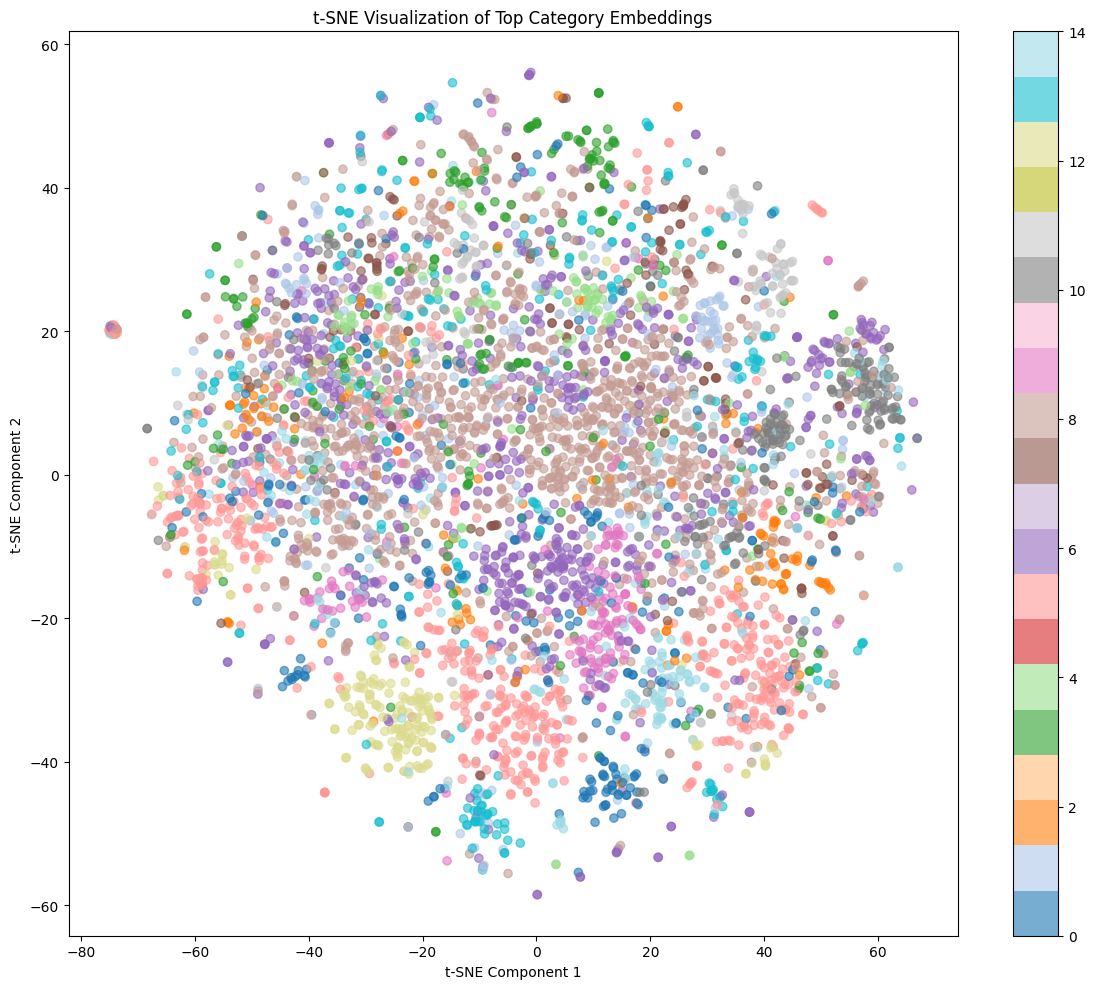

Training hierarchical models for bottom category prediction...
Training bottom category models in parallel with 4 jobs
Predicting bottom categories hierarchically...


In [ ]:
# ------------------------------
# 6. Model Training
# ------------------------------
def train_top_category_classifier(train_features, top_category_labels_train, 
                                 test_features, top_category_labels_test):
    """Train top category classifier with cross-validation"""
    print("Training top category classifier with XGBoost and cross-validation")
    
    # Configure XGBoost parameters
    xgb_params = {
        'n_estimators': 250,
        'max_depth': 8,
        'learning_rate': 0.05,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'random_state': RANDOM_STATE
    }
    
    # Add GPU support if enabled
    if USE_GPU:
        try:
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['gpu_id'] = 0
            print("Using GPU acceleration for XGBoost")
        except Exception as e:
            print(f"GPU acceleration failed, falling back to CPU")
            xgb_params['tree_method'] = 'hist'
    
    # Cross-validation for top model
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    top_cv_scores = []
    top_models = []
    top_predictions_proba_test = np.zeros((test_features.shape[0], 
                                          len(np.unique(top_category_labels_train))))
    
    print(f"Performing {N_FOLDS}-fold cross-validation for top category model")
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_features, top_category_labels_train)):
        print(f"Training fold {fold+1}/{N_FOLDS}")
        
        # Split data for this fold
        X_fold_train, X_fold_val = train_features[train_idx], train_features[val_idx]
        y_fold_train, y_fold_val = top_category_labels_train[train_idx], top_category_labels_train[val_idx]
        
        # Train model
        xgb_model = xgb.XGBClassifier(**xgb_params)
        xgb_model.fit(X_fold_train, y_fold_train)
        
        # Evaluate on validation fold
        y_fold_pred = xgb_model.predict(X_fold_val)
        fold_accuracy = accuracy_score(y_fold_val, y_fold_pred)
        fold_f1 = f1_score(y_fold_val, y_fold_pred, average='macro')
        print(f"Fold {fold+1} - Accuracy: {fold_accuracy:.4f}, F1: {fold_f1:.4f}")
        top_cv_scores.append((fold_accuracy, fold_f1))
        
        # Save model
        top_models.append(xgb_model)
        
        # Accumulate test predictions for ensemble
        top_predictions_proba_test += xgb_model.predict_proba(test_features) / N_FOLDS
    
    # Calculate average CV scores
    avg_cv_accuracy = np.mean([score[0] for score in top_cv_scores])
    avg_cv_f1 = np.mean([score[1] for score in top_cv_scores])
    print(f"Average CV Accuracy: {avg_cv_accuracy:.4f}, F1: {avg_cv_f1:.4f}")
    
    # Make final predictions on test set
    top_predictions_test = np.argmax(top_predictions_proba_test, axis=1)
    
    
    return top_models, top_predictions_test, top_predictions_proba_test

top_models, top_predictions_test, top_predictions_proba_test = train_top_category_classifier(
    combined_features_train,
    top_category_labels_train,
    combined_features_test,
    top_category_labels_test
)

def evaluate_classification(true_labels, predicted_labels, category_type="top"):
    """Evaluate classification results with multiple metrics"""
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1_macro = f1_score(true_labels, predicted_labels, average='macro')
    f1_weighted = f1_score(true_labels, predicted_labels, average='weighted')
    
    print(f"{category_type.capitalize()} category test results:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Macro F1: {f1_macro:.4f}")
    print(f"Test Weighted F1: {f1_weighted:.4f}")
    
    # Generate classification report
    class_report = classification_report(true_labels, predicted_labels)
    print(f"Classification Report - {category_type.capitalize()} Category:\n{class_report}")
    
    # Save report to file
    
    return accuracy, f1_macro, f1_weighted

evaluate_classification(
    true_labels=top_category_labels_test,
    predicted_labels=top_predictions_test,
    category_type="top"
)
def visualize_embeddings(features, labels, title, filename):
    """Create embedding visualization with t-SNE or UMAP"""
    from sklearn.manifold import TSNE
    
    # Use a sample if there are too many points
    max_points = 5000
    if len(features) > max_points:
        sample_idx = np.random.choice(len(features), max_points, replace=False)
        sample_features = features[sample_idx]
        sample_labels = labels[sample_idx]
    else:
        sample_features = features
        sample_labels = labels
    
    # Apply t-SNE
    print(f"Applying t-SNE for visualization of {title}...")
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
    tsne_result = tsne.fit_transform(sample_features)
    
    # Create plot
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=sample_labels, cmap='tab20', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    
    plt.tight_layout()
    plt.show()

visualize_embeddings(
    features=combined_features_train,
    labels=top_category_labels_train,
    title="t-SNE Visualization of Top Category Embeddings",
    filename="tsne_top_categories.png"
)
def train_bottom_category_classifiers_hierarchically(train_features, top_category_labels_train, 
                                                    bottom_category_labels_train_grouped):
    """Train bottom category models for each top category"""
    print("Training hierarchical models for bottom category prediction...")
    
    unique_top_categories = np.unique(top_category_labels_train)
    bottom_category_models = {}
    
    # Helper function to train a model for a specific top category
    def train_bottom_model(top_cat, train_data, top_train_labels, bottom_train_labels,
                           min_samples=MIN_SAMPLES_BOTTOM_CAT, use_smote=USE_SMOTE):
        """Train a model for a specific top category"""
        # Filter data for this top category
        mask_train = top_train_labels == top_cat
        X_train_cat = train_data[mask_train]
        y_bottom_train_cat = bottom_train_labels[mask_train]
        
        # Remove invalid labels (e.g., -1)
        valid_mask = y_bottom_train_cat != -1
        X_train_cat = X_train_cat[valid_mask]
        y_bottom_train_cat = y_bottom_train_cat[valid_mask]
        
        # Skip if all samples have the same bottom category or too few samples
        unique_values = np.unique(y_bottom_train_cat)
        if len(unique_values) <= 1 or len(y_bottom_train_cat) < 10:
            most_common = unique_values[0] if len(unique_values) > 0 else -1
            print(f"Top category {top_cat} has only one bottom category or too few samples: {most_common}")
            return top_cat, most_common  # Return the category value directly
        
        # Apply SMOTE for imbalanced classes
        if use_smote and (len(np.unique(y_bottom_train_cat)) > 1 and
                         len(np.unique(y_bottom_train_cat)) < 50 and  # Limit for SMOTE
                         len(y_bottom_train_cat) >= 50):  # Enough samples
            try:
                # Use SMOTE for oversampling
                smote = SMOTE(random_state=RANDOM_STATE)
                X_resampled, y_resampled = smote.fit_resample(X_train_cat, y_bottom_train_cat)
                
                # Choose classifier based on number of classes
                if len(np.unique(y_bottom_train_cat)) > 100:
                    # Use LightGBM for many classes
                    clf_params = {
                        'n_estimators': 150,
                        'max_depth': 12,
                        'learning_rate': 0.05,
                        'random_state': RANDOM_STATE,
                        'n_jobs': 1  # For parallel processing
                    }
                    if USE_GPU:
                        clf_params['device'] = 'gpu'
                    clf = lgb.LGBMClassifier(**clf_params)
                else:
                    # Use XGBoost for fewer classes
                    clf_params = {
                        'n_estimators': 150,
                        'max_depth': 10,
                        'learning_rate': 0.05,
                        'random_state': RANDOM_STATE,
                        'n_jobs': 1,
                        'tree_method': 'hist'
                    }
                    if USE_GPU:
                        clf_params['tree_method'] = 'gpu_hist'
                    clf = xgb.XGBClassifier(**clf_params)
                
                # Train on resampled data
                clf.fit(X_resampled, y_resampled)
                return top_cat, clf
            except Exception as e:
                print(f"Error with SMOTE for top category {top_cat}: {e}")
        
        # Regular training (no SMOTE or if SMOTE failed)
        try:
            if len(np.unique(y_bottom_train_cat)) > 100:
                # Use LightGBM for many classes
                clf_params = {
                    'n_estimators': 150,
                    'max_depth': 12,
                    'learning_rate': 0.05,
                    'class_weight': 'balanced',
                    'random_state': RANDOM_STATE,
                    'n_jobs': 1
                }
                if USE_GPU:
                    clf_params['device'] = 'gpu'
                clf = lgb.LGBMClassifier(**clf_params)
            else:
                # Use XGBoost for fewer classes
                clf_params = {
                    'n_estimators': 150,
                    'max_depth': 10,
                    'learning_rate': 0.05,
                    'random_state': RANDOM_STATE,
                    'n_jobs': 1,
                    'tree_method': 'hist'
                }
                if USE_GPU:
                    clf_params['tree_method'] = 'gpu_hist'
                clf = xgb.XGBClassifier(**clf_params)
            
            clf.fit(X_train_cat, y_bottom_train_cat)
            return top_cat, clf
        except Exception as e:
            print(f"Error training model for top category {top_cat}: {e}")
            
            # Fallback to most common class
            most_common = np.bincount(y_bottom_train_cat).argmax()
            return top_cat, most_common
    
    # Train models in parallel or sequentially
    if USE_PARALLEL:
        # Train models in parallel
        n_jobs = min(os.cpu_count() - 1, 4)  # Limit to avoid memory issues
        print(f"Training bottom category models in parallel with {n_jobs} jobs")
        results = Parallel(n_jobs=n_jobs)(
            delayed(train_bottom_model)(
                top_cat, train_features, top_category_labels_train, bottom_category_labels_train_grouped
            )
            for top_cat in unique_top_categories
        )
        # Convert results to dictionary
        bottom_category_models = dict(results)
    else:
        # Sequential training
        print("Training bottom category models sequentially")
        for top_cat in unique_top_categories:
            result = train_bottom_model(top_cat, train_features, top_category_labels_train, 
                                       bottom_category_labels_train_grouped)
            bottom_category_models[result[0]] = result[1]
    
    
    return bottom_category_models

bottom_category_models = train_bottom_category_classifiers_hierarchically(
    combined_features_train,
    top_category_labels_train,
    bottom_category_labels_train_grouped
)
def predict_bottom_categories(top_predictions_test, test_features, bottom_category_models):
    """Predict bottom categories using hierarchical approach"""
    print("Predicting bottom categories hierarchically...")
    bottom_predictions_test = np.zeros_like(top_predictions_test)
    
    # Predict in batches to manage memory usage
    for i in range(0, len(top_predictions_test), BATCH_SIZE):
        batch_end = min(i + BATCH_SIZE, len(top_predictions_test))
        batch_top_preds = top_predictions_test[i:batch_end]
        batch_features = test_features[i:batch_end]
        
        for j, top_pred in enumerate(batch_top_preds):
            # Get model for predicted top category
            bottom_model = bottom_category_models.get(top_pred)
            
            # Handle case with single value or no model
            if bottom_model is None or isinstance(bottom_model, (int, float, np.integer)):
                bottom_cat = bottom_model if bottom_model is not None else -1
                bottom_predictions_test[i+j] = bottom_cat
            else:
                # Use model to predict bottom category
                try:
                    bottom_predictions_test[i+j] = bottom_model.predict([batch_features[j]])[0]
                except Exception as e:
                    # Fallback in case of prediction error
                    print(f"Error predicting bottom category: {e}")
                    bottom_predictions_test[i+j] = -1
    
    return bottom_predictions_test

bottom_predictions_test = predict_bottom_categories(
    top_predictions_test,
    combined_features_test,
    bottom_category_models
)

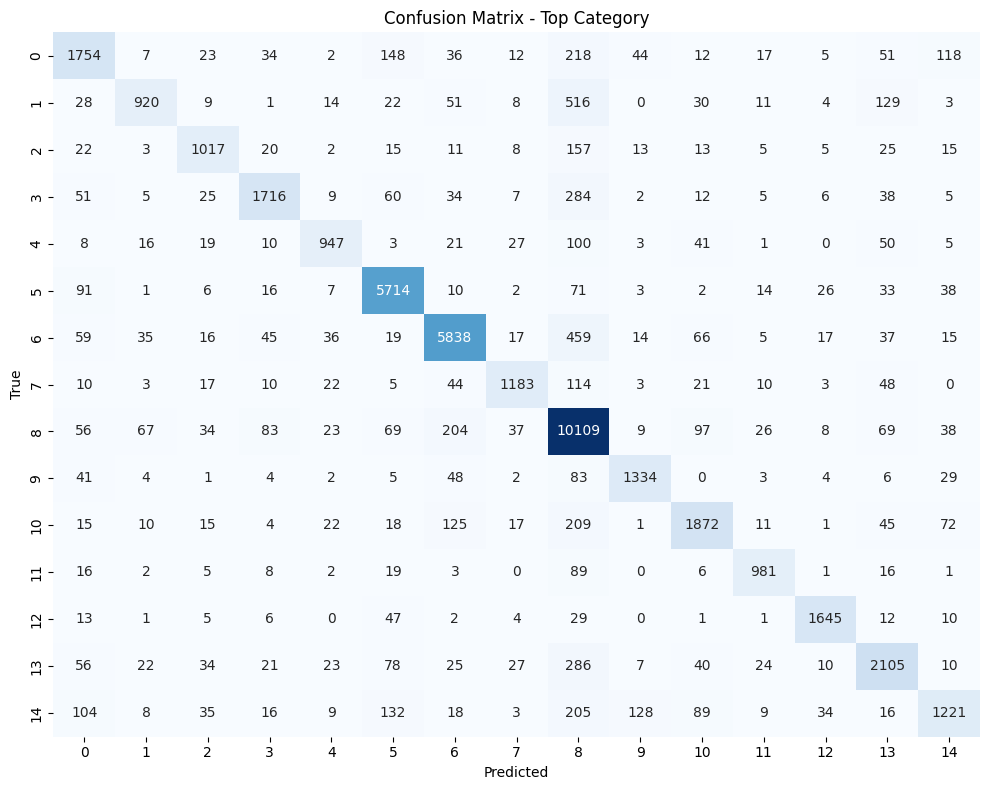

In [ ]:
# ------------------------------
# 7. Visualization Functions
# ------------------------------
def plot_confusion_matrix(true_labels, predicted_labels, title, filename):
    """Plot and save confusion matrix"""
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(PLOTS_DIR, filename))
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(
    true_labels=top_category_labels_test,
    predicted_labels=top_predictions_test,
    title="Confusion Matrix - Top Category",
    filename="confusion_matrix_top_category.png"
)

def plot_confusion_matrix_bottom(true_labels, predicted_labels, title, filename):
    """Plot and save confusion matrix"""
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(PLOTS_DIR, filename))
    plt.tight_layout()
    plt.show()

plot_confusion_matrix_bottom(
    true_labels=bottom_category_labels_test,
    predicted_labels=bottom_predictions_test,
    title="Confusion Matrix - Bottom Category",
    filename="confusion_matrix_bottom_category.png"
)
def plot_category_distribution(category_labels, title, filename):
    """Plot and save category distribution"""
    plt.figure(figsize=(12, 6))
    
    # Count occurrences of each category
    unique_cats, counts = np.unique(category_labels, return_counts=True)
    
    # Sort by count (descending)
    sorted_idx = np.argsort(-counts)
    sorted_cats = unique_cats[sorted_idx]
    sorted_counts = counts[sorted_idx]
    
    # Display only top 20 categories if there are many
    if len(sorted_cats) > 20:
        sorted_cats = sorted_cats[:20]
        sorted_counts = sorted_counts[:20]
        title += " (Top 20)"
    
    # Create bar plot
    plt.bar(range(len(sorted_cats)), sorted_counts)
    plt.xticks(range(len(sorted_cats)), sorted_cats, rotation=90)
    plt.title(title)
    plt.xlabel('Category ID')
    plt.ylabel('Count')
    plt.savefig(os.path.join(PLOTS_DIR, filename))
    plt.tight_layout()
    plt.show()

plot_category_distribution(
    category_labels=top_category_labels_train,
    title="Top Category Distribution (Train)",
    filename="top_category_distribution_train.png"
)

def plot_category_distribution_bottom(category_labels, title, filename):
    """Plot and save category distribution"""
    plt.figure(figsize=(12, 6))
    
    # Count occurrences of each category
    unique_cats, counts = np.unique(category_labels, return_counts=True)
    
    # Sort by count (descending)
    sorted_idx = np.argsort(-counts)
    sorted_cats = unique_cats[sorted_idx]
    sorted_counts = counts[sorted_idx]
    
    # Display only top 20 categories if there are many
    if len(sorted_cats) > 20:
        sorted_cats = sorted_cats[:20]
        sorted_counts = sorted_counts[:20]
        title += " (Top 20)"
    
    # Create bar plot
    plt.bar(range(len(sorted_cats)), sorted_counts)
    plt.xticks(range(len(sorted_cats)), sorted_cats, rotation=90)
    plt.title(title)
    plt.xlabel('Category ID')
    plt.ylabel('Count')
    plt.savefig(os.path.join(PLOTS_DIR, filename))
    plt.tight_layout()
    plt.show()

plot_category_distribution(
    category_labels=bottom_category_labels_train,
    title="Bottom Category Distribution (Train)",
    filename="bottom_category_distribution_train.png"
)

In [ ]:
# ------------------------------
# 8. Test Set Prediction Functions
# ------------------------------
def preprocess_test_data():
    # Store product ids for later
    test_product_ids = test_data["product_id"].copy()
    
    # Drop ID columns to prevent data leakage
    ID_COLUMNS = ['product_id']
    test_data = test_data.drop(columns=[col for col in ID_COLUMNS if col in test_data.columns])
    
    # Handle missing values in text columns
    # Handle missing values in text columns
    text_columns = ['title', 'description', 'tags']
    existing_text_columns = [col for col in text_columns if col in test_data.columns]
    test_data[existing_text_columns] = test_data[existing_text_columns].fillna("")

    
    # Check for cleaned text columns or use original
    text_columns_clean = ['title_clean', 'description_clean', 'tags_clean']
    use_clean_text = all(col in test_data.columns for col in text_columns_clean)
    
    # Create text length features
    if 'title' in test_data.columns and 'title_length' not in test_data.columns:
        test_data['title_length'] = test_data['title'].str.len()
    if 'description' in test_data.columns and 'description_length' not in test_data.columns:
        test_data['description_length'] = test_data['description'].str.len()
    if 'tags' in test_data.columns and 'tags_length' not in test_data.columns:
        test_data['tags_length'] = test_data['tags'].str.len()
        test_data['tags_count'] = test_data['tags'].str.count(' ') + 1
    
    # Create combined text
    if use_clean_text:
        test_data['combined_text'] = (
            test_data['title_clean'] + ' ' + 
            test_data['description_clean'] + ' ' + 
            test_data['tags_clean']
        )
    else:
        test_data['combined_text'] = (
            test_data['title'] + ' ' + 
            test_data['description'] + ' ' + 
            test_data['tags']
        )
    
    return test_data, test_product_ids, use_clean_text
test_data, test_product_ids, use_clean_text = preprocess_test_data()

def extract_features_from_test_data(test_data, tfidf=None, svd=None, categorical_transformer=None, 
                                  numeric_transformer=None, bert_model=None):
    """Extract features from test data using trained transformers"""
    print("Extracting features from test data...")
    
    # Define categorical and numeric features if available
    categorical_features = [col for col in test_data.columns 
                           if col.startswith('is_') or col.endswith('_category')]
    numeric_features = [col for col in test_data.columns 
                       if col.endswith('_length') or col.endswith('_count') 
                       or col.endswith('_value') or col.endswith('_price')]
    
    tfidf_features_test = None
    bert_features_test = None
    
    # Extract TF-IDF features
    if USE_TFIDF and tfidf is not None:
        print("Applying TF-IDF transformation to test data...")
        test_text_features = tfidf.transform(test_data['combined_text'])
        
        if USE_FLOAT32:
            test_text_features = test_text_features.astype(np.float32)
        
        # Categorical features
        if categorical_features and categorical_transformer is not None and USE_METADATA:
            test_categorical_features = categorical_transformer.transform(test_data[categorical_features])
            if USE_FLOAT32:
                test_categorical_features = test_categorical_features.astype(np.float32)
        else:
            test_categorical_features = csr_matrix((test_data.shape[0], 0))
        
        # Numeric features
        if numeric_features and numeric_transformer is not None and USE_METADATA:
            test_numeric_features = numeric_transformer.transform(test_data[numeric_features])
            if USE_FLOAT32:
                test_numeric_features = test_numeric_features.astype(np.float32)
        else:
            test_numeric_features = np.zeros((test_data.shape[0], 0))
        
        # Combine features
        test_combined_features = hstack([
            test_text_features, 
            test_categorical_features, 
            csr_matrix(test_numeric_features)
        ])
        
        # Apply SVD for dimensionality reduction
        if svd is not None:
            tfidf_features_test = svd.transform(test_combined_features)
            if USE_FLOAT32:
                tfidf_features_test = tfidf_features_test.astype(np.float32)
            
            print(f"TF-IDF+SVD test feature matrix shape: {tfidf_features_test.shape}")
    
    # Extract BERT embeddings
    if USE_BERT and bert_model is not None:
        print("Extracting BERT embeddings for test data...")
        
        # Extract embeddings in batches to manage memory usage
        def extract_embeddings_in_batches(texts, batch_size=32):
            all_embeddings = []
            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i+batch_size]
                batch_embeddings = bert_model.encode(batch_texts, show_progress_bar=True)
                all_embeddings.append(batch_embeddings)
            return np.vstack(all_embeddings)
        
        bert_features_test = extract_embeddings_in_batches(test_data['combined_text'].tolist())
        
        if USE_FLOAT32:
            bert_features_test = bert_features_test.astype(np.float32)
        
        print(f"BERT test feature matrix shape: {bert_features_test.shape}")
    
    # Combine features from multiple pipelines
    if tfidf_features_test is not None and bert_features_test is not None:
        print("Combining TF-IDF+SVD and BERT features for test data...")
        combined_test_features = np.hstack([tfidf_features_test, bert_features_test])
        print(f"Combined test feature matrix shape: {combined_test_features.shape}")
    elif tfidf_features_test is not None:
        print("Using only TF-IDF+SVD features for test data...")
        combined_test_features = tfidf_features_test
    elif bert_features_test is not None:
        print("Using only BERT features for test data...")
        combined_test_features = bert_features_test
    else:
        raise ValueError("At least one feature extraction method must be enabled")
    
    return combined_test_features

test_data_features = extract_features_from_test_data(
    test_data=test_data,
    tfidf=tfidf_vectorizer,
    svd=svd_model,
    categorical_transformer=categorical_encoder,
    numeric_transformer=numeric_scaler,
    bert_model=bert_model
)

def predict_categories_for_test_set(test_data_features, top_models, bottom_category_models):
    """Make predictions for test set using trained models"""
    print("Making predictions for test dataset...")
    
    # Predict top categories using ensemble of top models
    top_predictions_proba = np.zeros((test_data_features.shape[0], len(top_models[0].classes_)))
    for model in top_models:
        # Predict in batches to manage memory
        for i in range(0, test_data_features.shape[0], BATCH_SIZE):
            batch_end = min(i + BATCH_SIZE, test_data_features.shape[0])
            batch_features = test_data_features[i:batch_end]
            top_predictions_proba[i:batch_end] += model.predict_proba(batch_features) / len(top_models)
    
    # Get the most likely class for each sample
    top_predictions = np.argmax(top_predictions_proba, axis=1)
    
    # Predict bottom categories hierarchically
    bottom_predictions = predict_bottom_categories(top_predictions, test_data_features, bottom_category_models)
    
    return top_predictions, bottom_predictions
top_predictions_testset, bottom_predictions_testset = predict_categories_for_test_set(
    test_data_features=test_data_features,
    top_models=top_models,
    bottom_category_models=bottom_category_models
)

def save_test_predictions(test_product_ids, top_predictions, bottom_predictions):
    """Save test predictions to file"""
    print("Saving test predictions...")
    
    # Create DataFrame with predictions
    test_predictions_df = pd.DataFrame({
        'product_id': test_product_ids,
        'predicted_top_category': top_predictions,
        'predicted_bottom_category': bottom_predictions
    })
    
    # Save as CSV and parquet
    test_predictions_df.to_csv(os.path.join(PREDICTIONS_DIR, "test_predictions.csv"), index=False)
    test_predictions_df.to_parquet(os.path.join(PREDICTIONS_DIR, "test_predictions.parquet"), index=False)
    
    print(f"Test predictions saved to {PREDICTIONS_DIR}")
    
    return test_predictions_df
test_predictions_df = save_test_predictions(
    test_product_ids=test_product_ids,
    top_predictions=top_predictions_testset,
    bottom_predictions=bottom_predictions_testset
)

In [ ]:
# ----------------------
# 9. Summary
# ----------------------
print(f"Successfully predicted {len(test_predictions_df)} test samples")
print(f"Top Categories Distribution: {test_predictions_df['predicted_top_category'].value_counts().to_dict()}")
print(f"Number of unique bottom categories predicted: {test_predictions_df['predicted_bottom_category'].nunique()}")